In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset, DatasetDict

sns.set_theme(context="paper", style="whitegrid", palette="Dark2")

## Sampling the data

In [3]:
data = pd.read_csv("/proj/mechanistic.shadow/mrofin/tinylinguist/data/valid_sentences.csv", sep="\t")
data["top_constituents"] = data["top_constituents"].apply(lambda s: s.replace("'", "").replace("`", "").strip())

data.head(5)

,text,top_constituents,tree_depth,length
0,"u don't have to be scared of the loud dog, I'l...",S S,6,13
1,The mole felt so safe with the little girl.,NP VP,3,9
2,She was very kind and the mole soon came to tr...,S CC S,3,12
3,He leaned against her and she kept him safe.,S CC S,2,9
4,The mole had found his best friend.,NP VP,2,7


In [4]:
data["top_constituents"].value_counts()[:10]

top_constituents
NP VP         321176
S CC S         32892
ADVP NP VP     28623
NP NP VP       26274
PP NP VP       11026
SBAR NP VP      9431
CC NP VP        9122
VP              5882
S  NP VP        4176
NP ADVP VP      3710
Name: count, dtype: int64

In [6]:
good_tc = data["top_constituents"].value_counts().index[:9].values
is_in_good_tc = data["top_constituents"].isin(good_tc)
data["tc_label"] = np.where(is_in_good_tc, data["top_constituents"], "other")
data["tc_prob"] = 1 / data["tc_label"].map(data["tc_label"].value_counts())

data.head()

,text,top_constituents,tree_depth,length,tc_label,tc_prob
0,"u don't have to be scared of the loud dog, I'l...",S S,6,13,other,0.000022
1,The mole felt so safe with the little girl.,NP VP,3,9,NP VP,0.000003
2,She was very kind and the mole soon came to tr...,S CC S,3,12,S CC S,0.000030
3,He leaned against her and she kept him safe.,S CC S,2,9,S CC S,0.000030
4,The mole had found his best friend.,NP VP,2,7,NP VP,0.000003


In [7]:
tc_samples = data.sample(110000, weights="tc_prob", random_state=42, replace=False, ignore_index=True)
dl_samples = data.sample(110000, random_state=42, replace=False, ignore_index=True)

In [15]:
from sklearn.model_selection import train_test_split

final_data = {}

final_data["tc_train"], final_data["tc_test"] = train_test_split(
    tc_samples, test_size=10000, random_state=42, stratify=tc_samples["tc_label"]
)
final_data["dl_train"], final_data["dl_test"] = train_test_split(dl_samples, test_size=10000, random_state=42)

## Saving the dataset

In [16]:
dataset = DatasetDict({
    key: Dataset.from_pandas(split.drop(columns=["top_constituents", "tc_prob"]), preserve_index=False)
    for key, split in final_data.items()
})

In [18]:
dataset.save_to_disk("/proj/mechanistic.shadow/mrofin/tinylinguist/data/val_linguistic_features")

Saving the dataset (0/1 shards):   0%|          | 0/100000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/100000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

## Visualizations

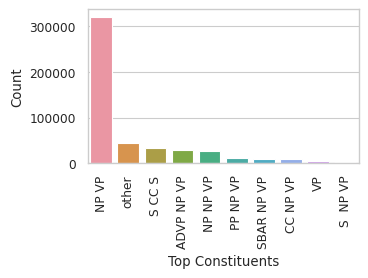

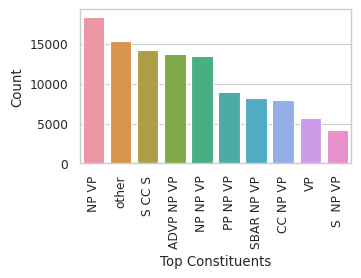

In [33]:
plt.figure(figsize=(3.5, 2))
tc = data["tc_label"].value_counts()
sns.barplot(x=tc.index, y=tc.values)
plt.xticks(rotation=90)
plt.xlabel("Top Constituents")
plt.ylabel("Count")
plt.savefig("img/top_constituents_before_sampling.pdf", bbox_inches="tight")
plt.show()

plt.figure(figsize=(3.5, 2))
tc = tc_samples["tc_label"].value_counts()
sns.barplot(x=tc.index, y=tc.values)
plt.xticks(rotation=90)
plt.xlabel("Top Constituents")
plt.ylabel("Count")
plt.savefig("img/top_constituents_after_sampling.pdf", bbox_inches="tight")
plt.show()

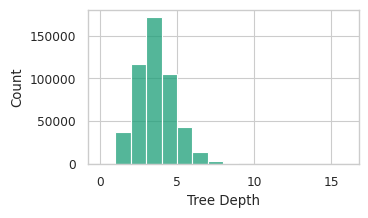

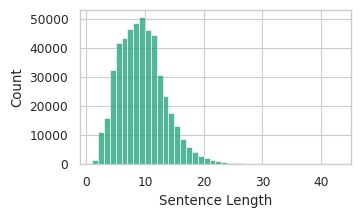

In [45]:
plt.figure(figsize=(3.5, 2))
sns.histplot(x=data["tree_depth"], bins=16)

plt.xlabel("Tree Depth")
plt.ylabel("Count")

plt.savefig("img/tree_depth.pdf", bbox_inches="tight")
plt.show()

plt.figure(figsize=(3.5, 2))
sns.histplot(x=data["length"], bins=42)

plt.xlabel("Sentence Length")
plt.ylabel("Count")

plt.savefig("img/sentence_length.pdf", bbox_inches="tight")
plt.show()